In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_resnet50.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(32, activation='relu'))
model_resnet50.add(Dense(32, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(5, activation="softmax"))
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            14812160  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 256)            394240    
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
dense (Dense)                (None, 7, 32)             8224      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 32)             1

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 71s 147ms/step - loss: 0.7303 - acc: 0.7280 - val_loss: 0.3298 - val_acc: 0.8707
Epoch 2/30
380/380 [==============================] - 42s 110ms/step - loss: 0.3321 - acc: 0.8811 - val_loss: 0.2087 - val_acc: 0.9297
Epoch 3/30
380/380 [==============================] - 42s 109ms/step - loss: 0.1864 - acc: 0.9332 - val_loss: 0.2184 - val_acc: 0.9328
Epoch 4/30
380/380 [==============================] - 41s 109ms/step - loss: 0.1059 - acc: 0.9632 - val_loss: 0.1998 - val_acc: 0.9491
Epoch 5/30
380/380 [==============================] - 42s 111ms/step - loss: 0.0784 - acc: 0.9714 - val_loss: 0.1871 - val_acc: 0.9470
Epoch 6/30
380/380 [==============================] - 42s 111ms/step - loss: 0.0688 - acc: 0.9793 - val_loss: 0.1960 - val_acc: 0.9389

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/30
380/380 [==============================] - 42s 111ms/step - loss: 0.0165 - acc: 0.9959 - val_loss:

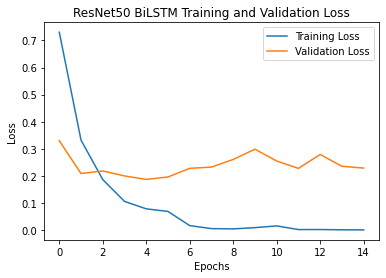

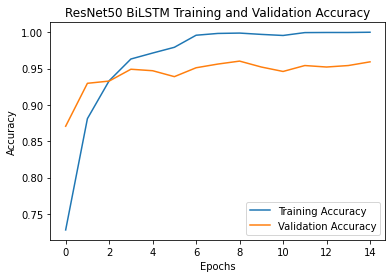

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 46ms/step - loss: 0.1871 - acc: 0.9470


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 46ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.91549   0.94660   0.93079       206
            covid19    0.94470   0.97156   0.95794       211
             normal    0.98980   0.92823   0.95802       209
       tuberculosis    0.96503   0.98571   0.97527       140
    viral_pneumonia    0.92958   0.91667   0.92308       216

           accuracy                        0.94705       982
          macro avg    0.94892   0.94976   0.94902       982
       weighted avg    0.94774   0.94705   0.94706       982



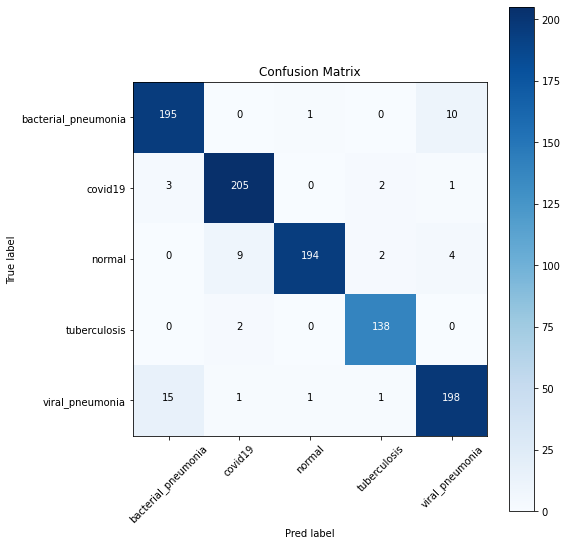

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 29s 77ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99424   0.99016   0.99220      1220
            covid19    0.98806   0.99839   0.99320      1243
             normal    0.98948   0.99028   0.98988      1235
       tuberculosis    0.99914   0.98974   0.99442      1170
    viral_pneumonia    0.99012   0.99175   0.99093      1212

           accuracy                        0.99211      6080
          macro avg    0.99221   0.99207   0.99213      6080
       weighted avg    0.99213   0.99211   0.99211      6080



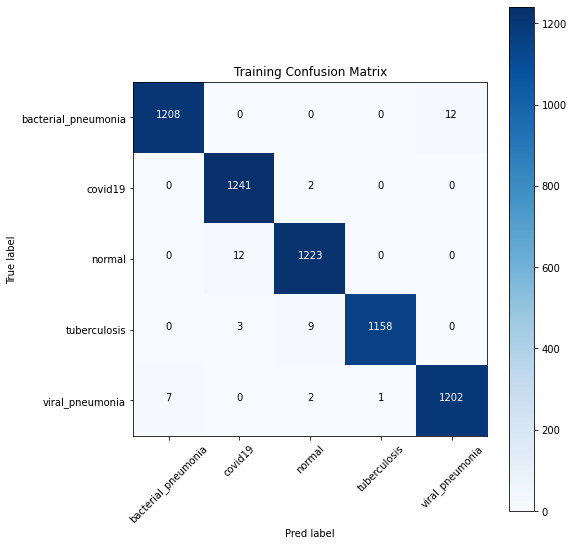

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_vgg19.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(32, activation='relu'))
model_vgg19.add(Dense(32, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 256)            394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 32)             8224      
_________________________________________________________________
dense_4 (Dense)              (None, 7, 32)            

In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 55s 126ms/step - loss: 2.0385 - acc: 0.2781 - val_loss: 1.4466 - val_acc: 0.3574
Epoch 2/30
380/380 [==============================] - 43s 114ms/step - loss: 1.4552 - acc: 0.3988 - val_loss: 1.3131 - val_acc: 0.4318
Epoch 3/30
380/380 [==============================] - 44s 114ms/step - loss: 1.2641 - acc: 0.4882 - val_loss: 1.1887 - val_acc: 0.5163
Epoch 4/30
380/380 [==============================] - 43s 114ms/step - loss: 1.1076 - acc: 0.5625 - val_loss: 1.1010 - val_acc: 0.5682
Epoch 5/30
380/380 [==============================] - 43s 113ms/step - loss: 0.9901 - acc: 0.6113 - val_loss: 1.0142 - val_acc: 0.6130
Epoch 6/30
380/380 [==============================] - 44s 114ms/step - loss: 0.8568 - acc: 0.6740 - val_loss: 0.9491 - val_acc: 0.6436
Epoch 7/30
380/380 [==============================] - 43s 114ms/step - loss: 0.7609 - acc: 0.7145 - val_loss: 0.8815 - val_acc: 0.6731
Epoch 8/30
380/380 [==============================] - 4

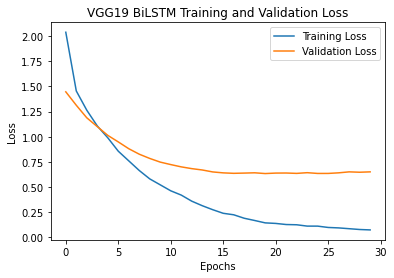

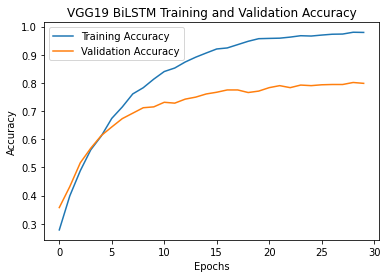

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 8s 63ms/step - loss: 0.6347 - acc: 0.7709


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 9s 63ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.71875   0.66990   0.69347       206
            covid19    0.81429   0.81043   0.81235       211
             normal    0.83744   0.81340   0.82524       209
       tuberculosis    0.81757   0.86429   0.84028       140
    viral_pneumonia    0.68559   0.72685   0.70562       216

           accuracy                        0.77088       982
          macro avg    0.77473   0.77697   0.77539       982
       weighted avg    0.77133   0.77088   0.77066       982



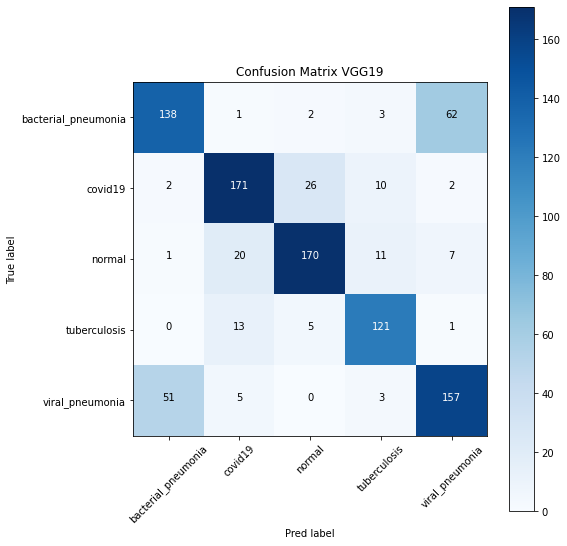

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 34s 89ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99508   0.99426   0.99467      1220
            covid19    0.99839   0.99839   0.99839      1243
             normal    0.99838   0.99919   0.99879      1235
       tuberculosis    0.99915   0.99915   0.99915      1170
    viral_pneumonia    0.99422   0.99422   0.99422      1212

           accuracy                        0.99704      6080
          macro avg    0.99704   0.99704   0.99704      6080
       weighted avg    0.99704   0.99704   0.99704      6080



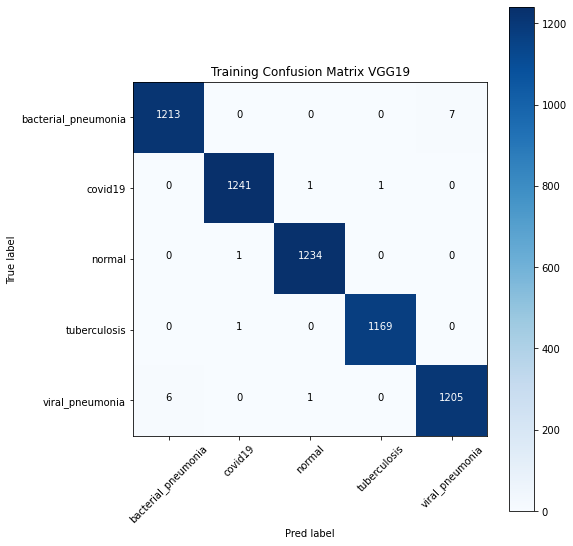

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_inceptionv3.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(32, activation='relu'))
model_inceptionv3.add(Dense(32, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            10617856  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5, 256)            394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 32)             8224      
_________________________________________________________________
dense_7 (Dense)              (None, 5, 32)            

In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 47s 103ms/step - loss: 1.0815 - acc: 0.5327 - val_loss: 0.7138 - val_acc: 0.6976
Epoch 2/30
380/380 [==============================] - 36s 94ms/step - loss: 0.7925 - acc: 0.6730 - val_loss: 0.6472 - val_acc: 0.7352
Epoch 3/30
380/380 [==============================] - 36s 94ms/step - loss: 0.6940 - acc: 0.7194 - val_loss: 0.5993 - val_acc: 0.7525
Epoch 4/30
380/380 [==============================] - 36s 94ms/step - loss: 0.6257 - acc: 0.7513 - val_loss: 0.5904 - val_acc: 0.7556
Epoch 5/30
380/380 [==============================] - 36s 95ms/step - loss: 0.5801 - acc: 0.7748 - val_loss: 0.5606 - val_acc: 0.7800
Epoch 6/30
380/380 [==============================] - 36s 94ms/step - loss: 0.5432 - acc: 0.7854 - val_loss: 0.5554 - val_acc: 0.7719
Epoch 7/30
380/380 [==============================] - 36s 94ms/step - loss: 0.5062 - acc: 0.8048 - val_loss: 0.5331 - val_acc: 0.7892
Epoch 8/30
380/380 [==============================] - 36s 93m

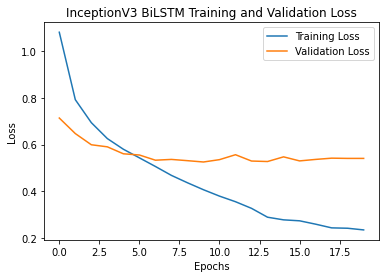

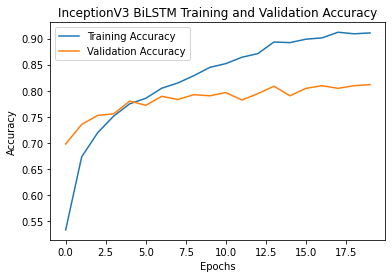

In [28]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 5s 41ms/step - loss: 0.5254 - acc: 0.7902


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 42ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.67089   0.77184   0.71783       206
            covid19    0.84360   0.84360   0.84360       211
             normal    0.82243   0.84211   0.83215       209
       tuberculosis    0.95349   0.87857   0.91450       140
    viral_pneumonia    0.73298   0.64815   0.68796       216

           accuracy                        0.79022       982
          macro avg    0.80468   0.79685   0.79921       982
       weighted avg    0.79420   0.79022   0.79065       982



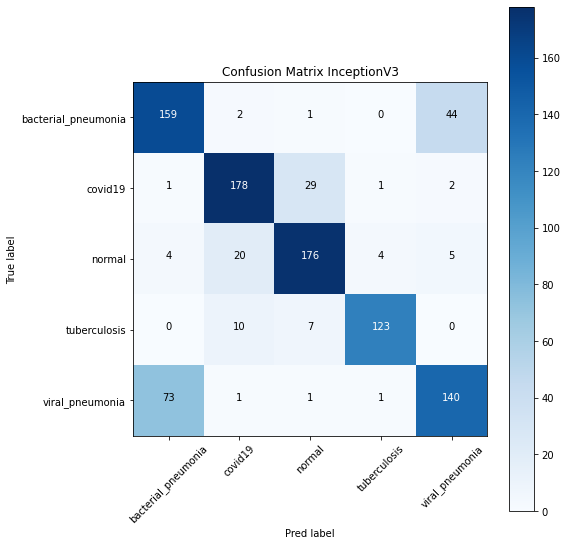

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [32]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 25s 66ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.81468   0.90082   0.85559      1220
            covid19    0.94476   0.93564   0.94018      1243
             normal    0.91467   0.92874   0.92166      1235
       tuberculosis    0.98404   0.94872   0.96606      1170
    viral_pneumonia    0.87299   0.80528   0.83777      1212

           accuracy                        0.90378      6080
          macro avg    0.90623   0.90384   0.90425      6080
       weighted avg    0.90580   0.90378   0.90401      6080



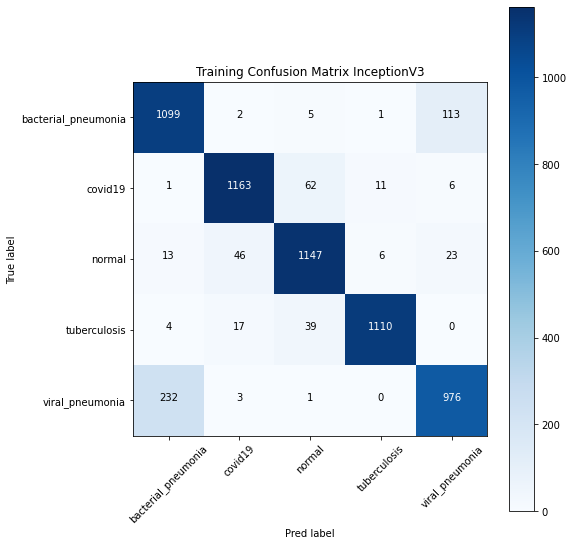

In [33]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()